In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt # for plotting
from matplotlib.axis import XAxis
from matplotlib.axis import YAxis
import torch.optim as optim #for gradient descent
import torchvision.models as models
import random
import torchvision.transforms as transforms
import os
import math
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score, hamming_loss
import torch.cuda as cuda
import logging

In [2]:
#this cell is just for reproducaibility, it sets the seed for random, numpy and torch. change the seed if you want different results

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
#this cell will load the data and put it into tensors for training

max_samples = 25000 #how many samples to use, -1 is all of them

#VGG_16 dataloader: its the same thing but the transforms are slightly off
#only works on dominiks computer
#adding a section to split data intro training/testing/validation
#just keeping it to 50k to make things easier

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128)),
    transforms.Normalize(mean = [0, 0, 0], std = [1, 1, 1])
])

totensor = transforms.ToTensor()

celeb_data = {}
k = os.listdir("celeba/img_align_celeba")

imageno = 0
with open("celeba/list_attr_celeba.csv") as labels:
    classes = labels.readline()
    classes = classes.split(sep = ",")

    for l in k:

        if(max_samples != -1 and imageno > max_samples):
            break

        lab = labels.readline().split(sep=",")
        lab[-1] = lab[-1].replace('\n', "")

        name = lab[0]
        lab.pop(0)
        #print(lab_copy)
        celeb_data[name] = (transform1(plt.imread("celeba/img_align_celeba/" + l)),(torch.FloatTensor([int(k) for k in lab])))
        imageno +=1
        
        #progress bar :)
        if(imageno%(max_samples/100) == 0):
            percent = round(imageno/max_samples*100, 3)
            percent = ('%.0f' %percent)
            print('\r' + str(percent) + "% Complete", end='', flush=True)

C:\Users\Dominik Danda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


100% Complete

In [4]:
#this cell will shuffle and split the dataset

sample_ratio = (8, 1, 1) #the ratio used to split the data, does not need to add up to 10
shuf_list = list(celeb_data.keys())
random.shuffle(shuf_list) 

imageno = 0
train_data = []
val_data = []
test_data = []

train_sample_num = sample_ratio[0]/math.fsum(sample_ratio)*max_samples
val_sample_num = sample_ratio[1]/math.fsum(sample_ratio)*max_samples
test_sample_num = sample_ratio[2]/math.fsum(sample_ratio)*max_samples

for i in shuf_list:
    if imageno < (train_sample_num):
        train_data.append(i)
    elif imageno >= (train_sample_num) and imageno < (train_sample_num+val_sample_num):
        val_data.append(i)
    else:
        test_data.append(i)
    imageno += 1

In [5]:
train_data_2 = []
counter = 0
for i in train_data:
    with torch.no_grad():
        j = celeb_data[i][0].cuda()
    train_data_2.append((j,celeb_data[i][1]))
    cuda.empty_cache()
     
    if(counter%(len(train_data)/100) == 0):
            percent = round(counter/len(train_data)*100, 3)
            percent = ('%.0f' %percent)
            print('\rTrain Data is ' + str(percent) + "% Complete", end='', flush=True) 
    counter += 1
print("\n")

val_data_2 = []
counter = 0
for i in val_data:
    with torch.no_grad():
        j = celeb_data[i][0].cuda()
    val_data_2.append((j,celeb_data[i][1]))
    cuda.empty_cache()
    
    if(counter%(len(val_data)/100) == 0):
            percent = round(counter/len(val_data)*100, 3)
            percent = ('%.0f' %percent)
            print('\rValidation Data is ' + str(percent) + "% Complete", end='', flush=True) 
    counter += 1
print("\n")

test_data_2 = []
counter = 0
for i in test_data:
    with torch.no_grad():
        j = celeb_data[i][0].cuda()
    test_data_2.append((j,celeb_data[i][1], i))
    cuda.empty_cache()
     
    if(counter%(len(test_data)/100) == 0):
            percent = round(counter/len(test_data)*100, 3)
            percent = ('%.0f' %percent)
            print('\rTest Data is ' + str(percent) + "% Complete", end='', flush=True) 
    counter += 1
print("\n")

Train Data is 99% Complete

Validation Data is 99% Complete

Test Data is 0% Complete



In [6]:
def get_model_name(name, batch_size, learning_rate, epoch):
    name = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return name

In [ ]:
#actual model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class primary_net(nn.Module):
    def __init__(self):
        super(primary_net, self).__init__()
        #convolutional
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias = True) #128*128*3 -> 128*128*64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias = True) #128*128*64 -> 64*64*64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias = True) #64*64*64 -> 64*64*128
        self.pool1 = nn.AvgPool2d(kernel_size=4, stride=4) #64*64*128 -> 16*16*128
        #self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias = True) #32*32*128 -> 32*32*256
        #self.conv5 = nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias = True) #32*32*256 -> 16*16*256
        #self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #16*16*256 -> 8*8*256

        #classifier
        self.fc1 = nn.Linear(16*16*128, 16, bias = True)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv3(F.relu(self.conv2(F.relu(self.conv1(x)))))))
        #x = self.pool2(F.relu(self.conv5(F.relu(self.conv4(x)))))
        x = x.view(-1, 16*16*128)
        x = self.fc1(x)
        #x = self.fc2(x)
        return x

#evaluate function
def primary_evaluate(model, data_list):
    criterion = nn.BCEWithLogitsLoss()
    total_err = 0
    total_loss = 0

    for i in range(len(data_list)):
        inputs = data_list[i][0]
        labels = data_list[i][1]

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        labels = torch.stack([labels])
        outputs = model(inputs)

        #compute loss using the criterion, and add to the total loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        '''
        Hamming Loss: Will compute the number of incorrectly predictions per label,
        and divide it by the total number of predictions in the label. 
        
        Example:
        Predicted label [0, 1, 0, 1, 0, 0]
        True label      [0, 1, 1, 0, 0, 1]
        
        Incorrect predictions: 3
        Total prediction: 6

        Hamming Loss = 3/6 = 0.5
        '''

        #compute error using Hamming Loss, and add to the total error
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        preds = (probs > 0.5).astype(int)
        targets_np = labels.cpu().numpy()
        error = hamming_loss(targets_np, preds)
        total_err += error
        
    #error and loss were stored as a running total 
    #to find the average, we divide by the # of samples    
    return (total_err/len(data_list), total_loss/len(data_list))

#training loop
def primary_train(model, train_list, val_list, epochs, learning_rate, batch_size):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = nn.BCEWithLogitsLoss()
    train_err = np.zeros(epochs)
    train_loss = np.zeros(epochs)
    val_err = np.zeros(epochs)
    val_loss = np.zeros(epochs)

    #state_dict_list = [] #gonna leave this unfinished for now
    epoch = 0
    
    for i in range(epochs):
        total_err = 0
        total_train_loss = 0
        counter = 0
        train_list_copy = train_list[:]
        random.shuffle(train_list_copy)
        
        while train_list_copy:
            batch = train_list_copy[:batch_size]
            train_list_copy = train_list_copy[batch_size:]

            inputs = torch.stack([i[0] for i in batch])
            labels = torch.stack([i[1] for i in batch])
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            
            outputs = model(inputs)
            
            #compute loss using the criterion, and add to the total loss
            loss = criterion(outputs, labels)
            #compute the gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #add loss to running total
            total_train_loss += loss.item()
            
            #compute error using Hamming Loss, and add to the total error
            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            targets_np = labels.cpu().numpy()
            error = hamming_loss(targets_np, preds)
            total_err += error 
            
            #progress bar to keep track of long epochs
            if(counter%(len(train_list)/100) == 0):
                percent = round(counter/(len(train_list))*100, 3)
                percent = ('%.0f' %percent)
                print('\rNext Epoch is ' + str(percent) + "% Complete", end='', flush=True) 
            counter += 1
        print("\n")
        
        #error and loss were stored as a running total 
        #to find the average, we divide by the # batch operations
        train_err[epoch] = float(total_err) / (len(train_list)/batch_size)
        train_loss[epoch] = float(total_train_loss) / (len(train_list)/batch_size)

        #evaluate model
        (val_err[epoch], val_loss[epoch]) = primary_evaluate(model, val_list)
        
        #print status of last completed epoch
        print(("Epoch {}: Train Error: {}, Train Loss: {} |"+
               "Validation Error: {}, Validation Loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        
        #keep track of the epoch with the lowest validation error
        if epoch > 0 and val_err[epoch] < np.min(val_err[:epoch]):
            best_epoch = epoch
            name = get_model_name("primary_net", batch_size, learning_rate, best_epoch)
            best_model_wts = model.state_dict()
            print("New best model found and saved")

        
        epoch += 1
        # Save the current model (checkpoint) to a file, checkpoint every epoch
        #not saving it to a file, I'm getting some runtime errors I don't wanna deal with, I'm just saving the state_dict


    #save the epoch with the lowest validation error to the disk
    torch.save(best_model_wts, "checkpoints/" + name)
    print('Finished Training')

    #plot training graphs
    plt.title("Train vs Validation Error (Lower is Better)")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    ax = plt.gca()
    ax.set_xlim([1, n])
    ax.set_ylim([0, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.grid() 
    plt.savefig("graphs/" + name + "_error.png")
    plt.show()

    plt.title("Train vs Validation Loss (Lower is Better)")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    ax = plt.gca()
    ax.set_xlim([1, n])
    ax.set_ylim([0, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.grid()
    plt.savefig("graphs/" + name + "_loss.png")
    plt.show()

In [8]:
net = primary_net()
net = net.cuda()

primary_train(net, train_data_2, val_data_2, epochs = 10, learning_rate = 0.0005, batch_size = 1)

Next Epoch is 99% Complete

Epoch 1: Train Error: 0.165390625, Train Loss: 0.38497242720387875 |Validation Error: 0.151225, Validation Loss: 0.34641992423534396
Next Epoch is 53% Complete

KeyboardInterrupt: 

In [ ]:
model = primary_net()
model = model.cuda()
model.load_state_dict(torch.load("checkpoints/model_primary_net_bs256_lr0.0005_epoch703"))

test_err = 0
test_loss = 0
(test_err, test_loss) = primary_evaluate(model, test_data_2)
print("Test Error: {}, Test Loss: {}".format(test_err, test_loss))

Test Error: 0.11060575769692123, Test Loss: 0.2546915303556765


['image_id', 'Bald', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Chubby', 'Gray_Hair', 'Male', 'No_Beard', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Straight_Hair', 'Wavy_Hair', 'Young\n']


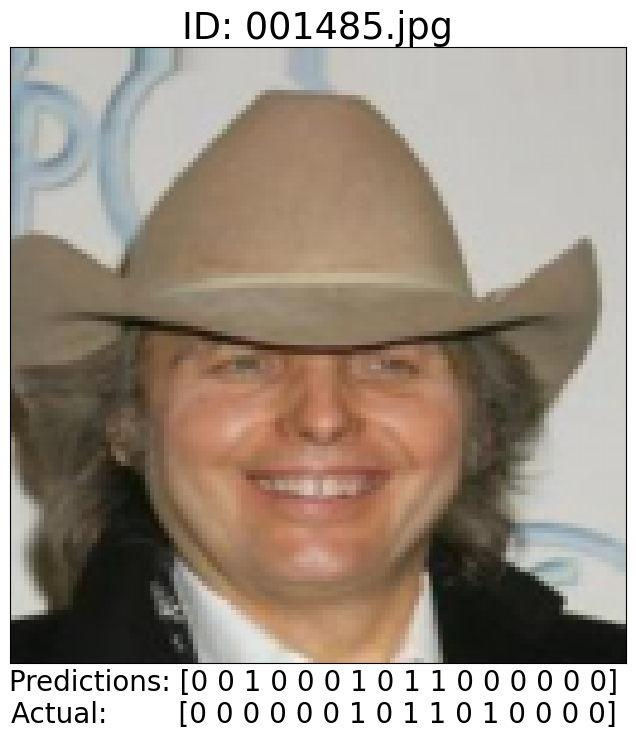

In [ ]:
#this cell will evaluate the model on the test data and save sample images

print(classes)

torch.no_grad()

newpath = r'graphs/tests/seed' + str(seed) + '_samples' + str(max_samples) + '_sampleratio' + str(sample_ratio[0]) + "-" + str(sample_ratio[1]) + "-" + str(sample_ratio[2])
if not os.path.exists(newpath):
    os.makedirs(newpath)

for i in range(20):
    inputs = test_data_2[i][0]
    labels = test_data_2[i][1]
    
    if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
    
    labels = torch.stack([labels])
    outputs = model(inputs)
    
    probs = torch.sigmoid(outputs).detach().cpu().numpy()
    preds = (probs > 0.5).astype(int)
    targets_np = labels.cpu().numpy()
    
    
    
    string = ""
    for j in preds:
        string += "Predictions: "
        for k in range(len(preds)):
            string += str(preds[k]) + " " 
        string += "\nActual:        "
        for k in range(len(targets_np)):
            string += str(targets_np[k].astype(int)) + " " 
        
    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.title("ID: " + test_data_2[i][2])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(string, horizontalalignment='center', fontsize=20)
    plt.rcParams.update({'font.size': 22})
    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    plt.imshow(celeb_data[test_data_2[i][2]][0].numpy().transpose(1,2,0))
    plt.savefig("graphs/tests/seed" + str(seed) + '_samples' + str(max_samples) + '_sampleratio' + str(sample_ratio[0]) + "-" + str(sample_ratio[1]) + "-" + str(sample_ratio[2]) + "\\" + test_data_2[i][2] + ".png")
    logger.setLevel(old_level)